`TODO`

> Waveforms of average signals  
> Time series data

# Imports

In [1]:
# Logging and warnings
import logging

# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm
import statsmodels.stats as st

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
# Set logging level for custom modules
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Set logging level for MNE
mne.set_log_level('WARNING')

In [5]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# READ DATA

---

---

# MAIN

##### `Pre-Processing`

In [6]:
# Instantiate NIRS() and read data
nirs = NIRS(project='Working-Memory') # Working-Memory # Multi-object Tracking
nirs.read(30, 1, 1, augment=False, transform=True, correction_factor=1.0, backlight=False);

In [7]:
nirs.raw.crop(tmax=3000)

<RawArray | 44 x 40002 (3000.0 s), ~13.5 MB, data loaded>

In [8]:
# nirs.save_short_channels()
# nirs.raw.drop_channels(utils.find_short_channels(nirs.raw.ch_names)[0])
# Filter frequencies outside hemodynamic response range
mne.filter.FilterMixin.filter(nirs.raw,
    l_freq=constants.F_L,
    h_freq=constants.F_H,
    l_trans_bandwidth=constants.L_TRANS_BANDWIDTH,
    h_trans_bandwidth=constants.H_TRANS_BANDWIDTH
);
# mne_nirs.signal_enhancement.enhance_negative_correlation(nirs.raw);

In [9]:
nirs.get_epochs(tmin=-2,
                tmax=12,
                baseline=(-0.5, 0),
                # reject_criteria={'hbo': 0.03, 'hbr': 0.03},
                plot_drop_log=False);

# Drop epochs where response was not correct
# nirs.epochs.drop(nirs.mat['id_correct'] != 1);

# nirs.block_average();

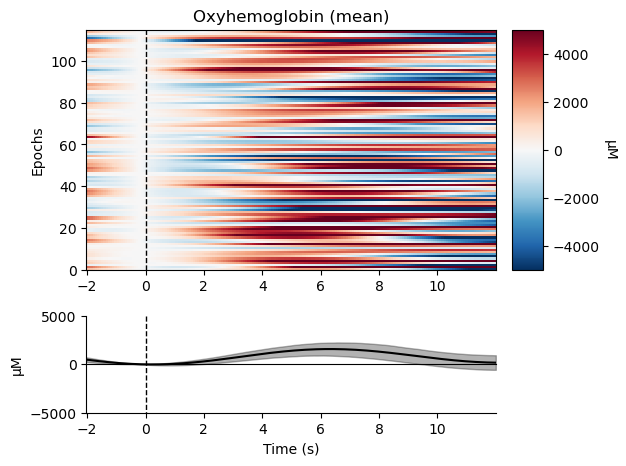

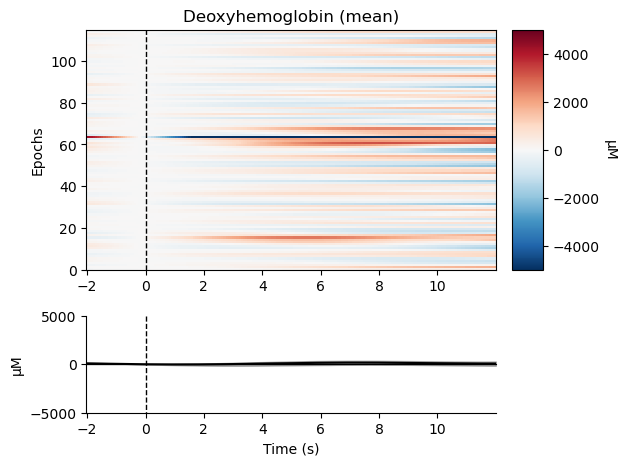

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [10]:
nirs.epochs['HIGH'].plot_image(combine='mean', vmin=-5000, vmax=5000, ts_args=dict(ylim=dict(hbo=[-5000, 5000], hbr=[-5000, 5000])))

##### `GLM Analysis`

In [11]:
# raw_intensity = savepoints['CW']
raw_haemo = nirs.raw.copy().pick(nirs.good_ch_names)

In [12]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                            drift_model=None, # 'cosine', 'polynomial'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

# design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [13]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)
glm_results = glm_est.to_dataframe()

In [14]:
glm_results['Significant'] = st.multitest.multipletests(glm_results['p_value'])[0]

In [15]:
glm_results_significant = glm_results[glm_results['Significant']]
significant_channels = list(glm_results_significant[glm_results_significant['Condition'] == 'HIGH']['ch_name'].unique())

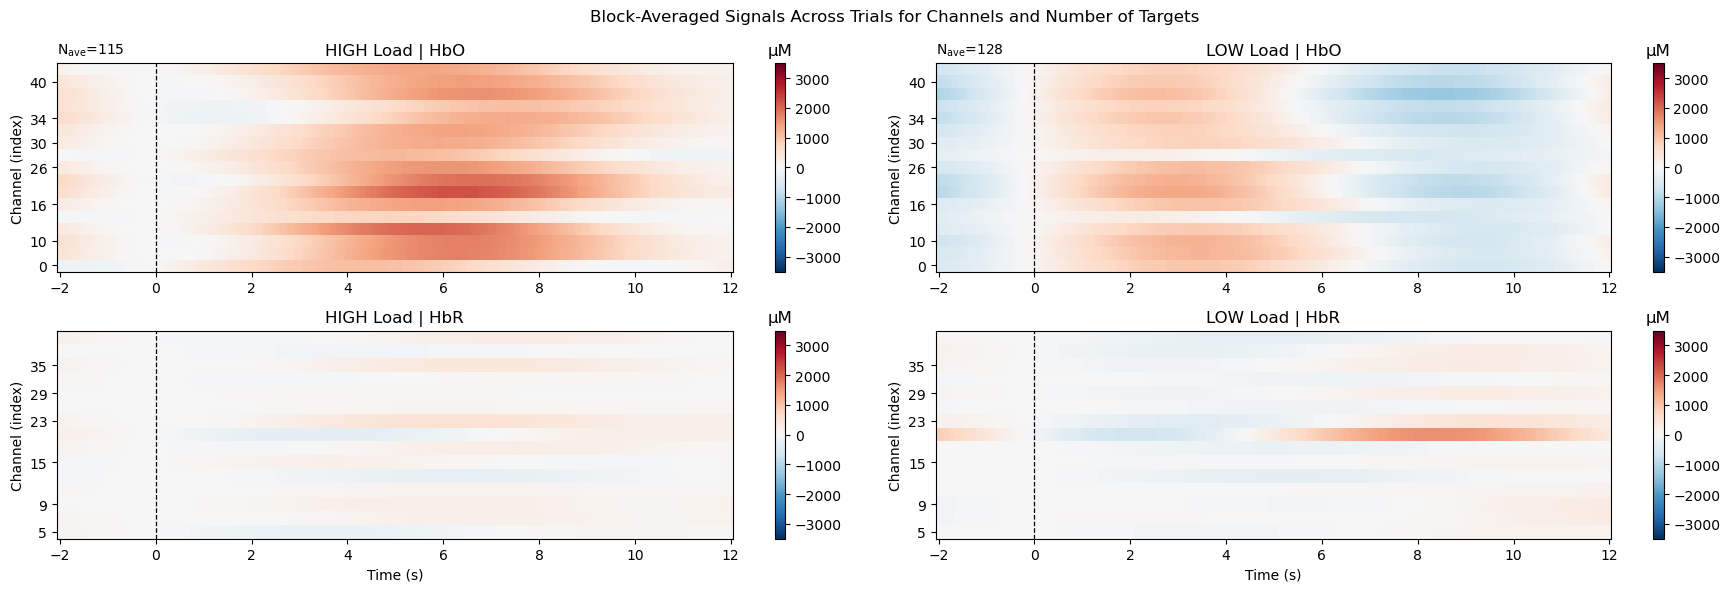

In [16]:
nirs.plot_average_heatmap(picks=significant_channels, clim={'hbo': [-3500, 3500], 'hbr': [-3500, 3500]}).tight_layout()

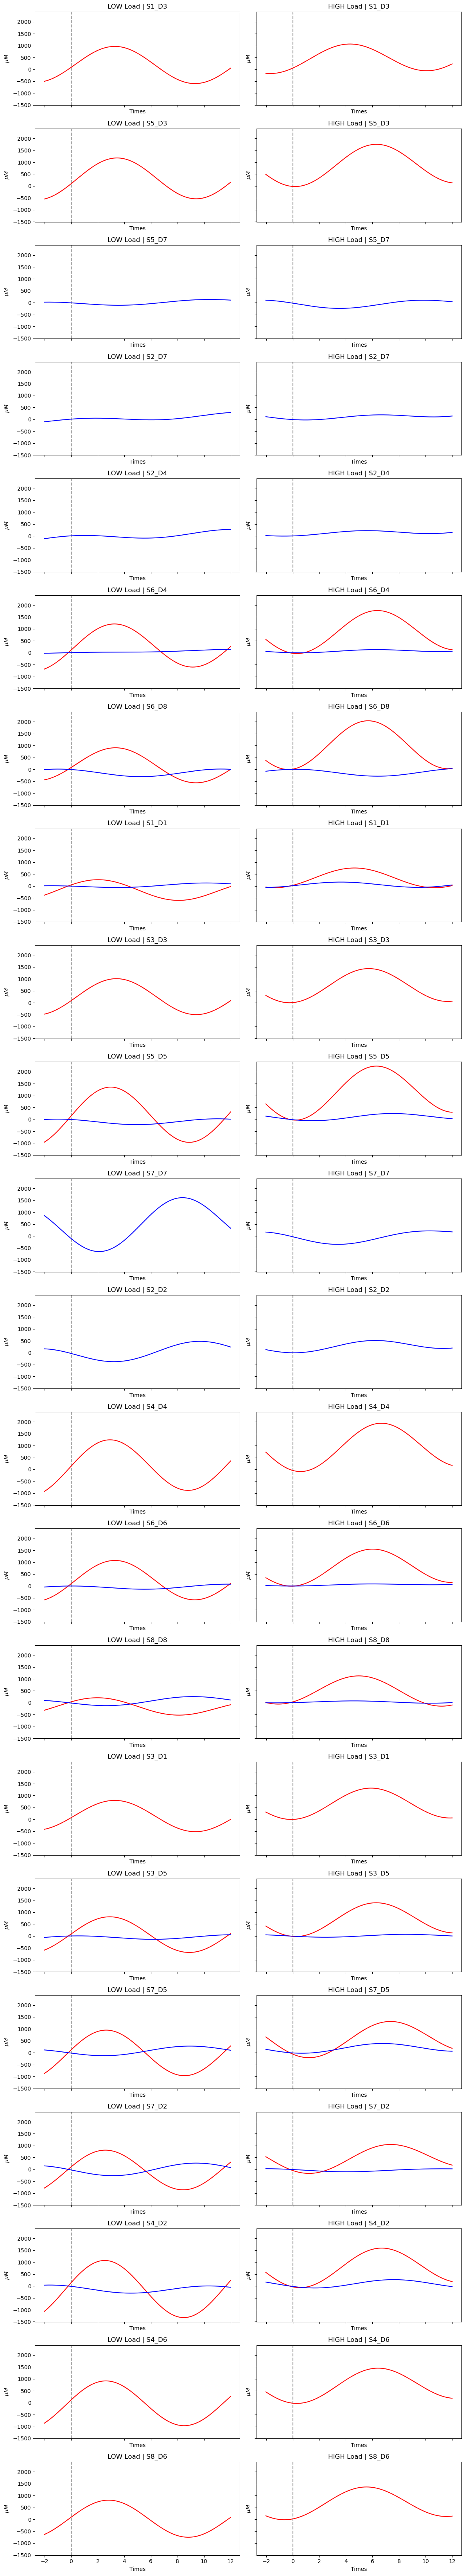

In [22]:
nirs.plot_average_waveform(picks=significant_channels, contrast_reference=None, cases=['LOW', 'HIGH'], title_format_hex=False, separate_cases=True, plot_individual_epochs=False, sharey=True).tight_layout()

In [19]:
contrast_results_significant = contrast_results[contrast_results['Significant']]
significant_channels_contrast = list(contrast_results_significant['ch_name'].unique())

##### `GLM Analysis (combined)`

In [22]:
nirs_1 = NIRS(project='Working-Memory').read(1, 1, 1, augment=True, transform=False, correction_factor=0.779)
nirs_2 = NIRS(project='Working-Memory').read(1, 1, 2, augment=True, transform=False, correction_factor=0.779)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:490: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  self.raw.set_annotations(mne.Annotations(
/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:490: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.raw.set_annotations(mne.Annotations(


In [23]:
savepoints_1 = nirs_1.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=True, short_channel_regression=False, bandpass=True, negative_correlation_enhancement=True, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007)
savepoints_2 = nirs_2.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=True, short_channel_regression=False, bandpass=True, negative_correlation_enhancement=True, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:578: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)
/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:578: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)


In [24]:
raw_haemo_1 = nirs_1.raw.copy()
raw_haemo_2 = nirs_2.raw.copy()

In [25]:
raw_haemo_1.info['bads'] = raw_haemo_2.info['bads'] = list(set(raw_haemo_1.info['bads'] + raw_haemo_1.info['bads']))
raw_haemo_combined = mne.concatenate_raws([raw_haemo_1, raw_haemo_2], preload=True, events_list=None, on_mismatch='raise', verbose=None)

In [26]:
design_matrix_combined = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo_combined,
                                                                                     hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                                     drift_model=None, # 'cosine', 'polynomial'
                                                                                     # drift_order=3,
                                                                                     # high_pass=1/2/(nirs.DUR['trial']),
                                                                                     stim_dur=nirs.DUR['motion'])

design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

design_matrix_combined.drop(columns=['BAD boundary'], inplace=True)
design_matrix_combined.drop(columns=['EDGE boundary'], inplace=True);

KeyboardInterrupt: 

In [ ]:
glm_est_combined = mne_nirs.statistics.run_glm(raw_haemo_combined, design_matrix_combined)

glm_results_combined = glm_est_combined.to_dataframe()

glm_results_combined['Significant'] = st.multitest.multipletests(glm_results_combined['p_value'])[0]

In [ ]:
glm_results_combined_significant = glm_results_combined[glm_results_combined['Significant']]

In [ ]:
significant_channels = list(glm_results_significant[glm_results_significant['Condition'] == 'HIGH']['ch_name'].unique())

# ips_channels = [f'{s_d} {ch_type}'
#                 for s_d in utils.hex_to_dec(['S22_D28', 'S22_D29', 'S22_D2B', 'S28_D22', 'S28_D29', 'S28_D2B', 'S29_D28', 'S29_D2B', 'S2B_D22', 'S2B_D28', 'S2B_D29']) # ['22', '28', '29', '2B']
#                 for ch_type in constants.HB_CHANNEL_TYPES]

# utils.dec_to_hex(list(set(ips_channels).intersection(set(significant_channels))))

##### `Plotting for GLM Analysis`

##### `Clustering`

> Relevant features  
>> For intervals of 1s in the epochs.  
>> - Area under the curve  
>> - Average slope  
>> - Maximum amplitude